<font color=blue><font size =6> Data Explanation </font></font><br>
이 데이터는 시계열 데이터 예측을 위한 Sample1(1)로 자세한 내용은 데이터 보안성에 의해 유출불가<font>
DeepAR로 Interval prediction을 해보겠다

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.models import DeepAR

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = pd.read_csv('../data/1.csv')
data.rename(columns={'a':'group_ids'},inplace=True)
data['group_ids']=np.tile('0',len(data))
data

,group_ids,b,values,c,d
0,0,2018-07-25 00:00:00,2755201,49886322546,4766059509
1,0,2018-07-25 00:01:00,2756000,49859101685,4747645421
2,0,2018-07-25 00:02:00,2755897,49878812122,4748030430
3,0,2018-07-25 00:03:00,2755301,49851370428,4753731716
4,0,2018-07-25 00:04:00,2756166,49843140981,4742659364
...,...,...,...,...,...
38875,0,2018-08-20 23:55:00,2789520,47854087962,4660630439
38876,0,2018-08-20 23:56:00,2788218,47881474848,4683950486
38877,0,2018-08-20 23:57:00,2789770,47862666882,4648584625
38878,0,2018-08-20 23:58:00,2788755,47840202650,4645764385


In [6]:
data.drop(columns=['c','d'],axis=1,inplace=True)

In [7]:
data

,group_ids,b,values
0,0,2018-07-25 00:00:00,2755201
1,0,2018-07-25 00:01:00,2756000
2,0,2018-07-25 00:02:00,2755897
3,0,2018-07-25 00:03:00,2755301
4,0,2018-07-25 00:04:00,2756166
...,...,...,...
38875,0,2018-08-20 23:55:00,2789520
38876,0,2018-08-20 23:56:00,2788218
38877,0,2018-08-20 23:57:00,2789770
38878,0,2018-08-20 23:58:00,2788755


In [8]:
data.isnull().sum()

group_ids    0
b            0
values       0
dtype: int64

<font size=6><font color = blue> Transforming to Pytorch-Forecasting Column Type </font></font>

Pytorch Forecasting은 Target의 type이 float일 것으로 예상한다. 따라서 우리는 sales colomn을 float형으로 만들어 줘야하고 추가로, Pytorch Forecasting은 Categorical variables를 integer가 아닌 string으로 해석 돼야 한다

In [9]:
data['time_idx'] = np.tile(np.arange(len(data)),1) # practice np.tile
data

,group_ids,b,values,time_idx
0,0,2018-07-25 00:00:00,2755201,0
1,0,2018-07-25 00:01:00,2756000,1
2,0,2018-07-25 00:02:00,2755897,2
3,0,2018-07-25 00:03:00,2755301,3
4,0,2018-07-25 00:04:00,2756166,4
...,...,...,...,...
38875,0,2018-08-20 23:55:00,2789520,38875
38876,0,2018-08-20 23:56:00,2788218,38876
38877,0,2018-08-20 23:57:00,2789770,38877
38878,0,2018-08-20 23:58:00,2788755,38878


In [15]:
data['b'] = pd.to_datetime(data['b'])
data['values'] = pd.to_numeric(data['values'],downcast='float')
data

,group_ids,b,values,time_idx
0,0,2018-07-25 00:00:00,2755201.0,0
1,0,2018-07-25 00:01:00,2756000.0,1
2,0,2018-07-25 00:02:00,2755897.0,2
3,0,2018-07-25 00:03:00,2755301.0,3
4,0,2018-07-25 00:04:00,2756166.0,4
...,...,...,...,...
38875,0,2018-08-20 23:55:00,2789520.0,38875
38876,0,2018-08-20 23:56:00,2788218.0,38876
38877,0,2018-08-20 23:57:00,2789770.0,38877
38878,0,2018-08-20 23:58:00,2788755.0,38878


<font size=6><font color = blue> Set TimeSeriesDataSet </font></font>

데이터는 총 38880개의 데이터를 갖고 있다 이를 train,test set으로 8:2의 비율로 나누고 train set에서 또 8:2의 비율로 validation set과 actual train set으로 나누겠다 따라서 다음의 데이터 개수를 갖게 된다

TestSet: 7776<br>
TrainSet: 24883<br>
ValidationSet: 6221

In [17]:
Training_cutoff = 24883
Train_df = data.iloc[:Training_cutoff+6221]
Test_df = data.iloc[Training_cutoff+6221:]

In [18]:
max_encoder_length = 60
max_prediction_length = 20
min_encoder_length = max_encoder_length
min_prediction_length = max_prediction_length

In [19]:
Train_tsd = TimeSeriesDataSet(
    data = Train_df.iloc[:Training_cutoff+1],
    time_idx = "time_idx",
    target = "values",
    group_ids = ["group_ids"],
    max_encoder_length = max_encoder_length,
    min_encoder_length = min_encoder_length,
    max_prediction_length = max_prediction_length,
    min_prediction_length = min_prediction_length,
    time_varying_unknown_reals = ["values"]
)
Train_tsd

TimeSeriesDataSet[length=24805](
	time_idx='time_idx',
	target='values',
	group_ids=['group_ids'],
	weight=None,
	max_encoder_length=60,
	min_encoder_length=60,
	min_prediction_idx=0,
	min_prediction_length=20,
	max_prediction_length=20,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=[],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['values'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'__group_id__group_ids': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={},
	randomize_length=None,
	predict_mode=False
)

In [20]:
Val_tsd = TimeSeriesDataSet.from_dataset(Train_tsd,
                                         Train_df,
                                         min_prediction_idx = Training_cutoff)
Val_tsd

TimeSeriesDataSet[length=6202](
	time_idx='time_idx',
	target='values',
	group_ids=['group_ids'],
	weight=None,
	max_encoder_length=60,
	min_encoder_length=60,
	min_prediction_idx=24883,
	min_prediction_length=20,
	max_prediction_length=20,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=[],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['values'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'__group_id__group_ids': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={},
	randomize_length=None,
	predict_mode=False
)

<font size=6><font color = blue> Set DataLoader </font></font>

#########problem#############

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_forecasting/data/samplers.py:86: UserWarning: Less than 256 samples available for 24805 prediction times. Use batch size smaller than 256. First 10 prediction times with small batch sizes: [61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
  warnings.warn(

<font color = blue>
같은 group id를 갖고 있을때 batch_size를 사용하지 못한다 따라서 다음과 같이 1개의 batch_size를 사용하게 된다</font>

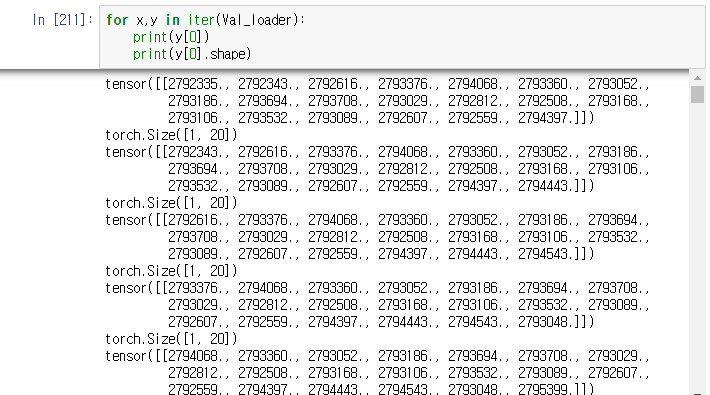

In [265]:
batch_size = 64
Train_loader = Train_tsd.to_dataloader(train = True,
                                       batch_size = batch_size,
                                       #batch_sampler = "synchronized",
                                       num_workers = 0)
Val_loader = Val_tsd.to_dataloader(train = False,
                                  batch_size = batch_size,
                                 #batch_sampler = "synchronized",
                                  num_workers = 0)

############################해결##############################
# syncronized를 꺼놓으니깐 batch_size 만큼 데이터가 뽑힘
# syncronized를 켜놓으면 내가 group id로 구분해놓은 cluster 갯수만큼만 batch를 만들 수 있음


In [267]:
num = 0
for x,y in iter(Val_loader):
    num = num+1
    print(y[0])
    print(y[0].shape)
    print(num)
# 순서대로 뽑힘을 확인 할 수 있음

tensor([[2792335., 2792343., 2792616.,  ..., 2792607., 2792559., 2794397.],
        [2792343., 2792616., 2793376.,  ..., 2792559., 2794397., 2794443.],
        [2792616., 2793376., 2794068.,  ..., 2794397., 2794443., 2794543.],
        ...,
        [2795746., 2795262., 2796482.,  ..., 2795060., 2794815., 2797869.],
        [2795262., 2796482., 2796036.,  ..., 2794815., 2797869., 2801842.],
        [2796482., 2796036., 2796754.,  ..., 2797869., 2801842., 2796203.]])
torch.Size([64, 20])
1
tensor([[2796036., 2796754., 2796176.,  ..., 2801842., 2796203., 2796945.],
        [2796754., 2796176., 2796737.,  ..., 2796203., 2796945., 2796319.],
        [2796176., 2796737., 2794968.,  ..., 2796945., 2796319., 2796567.],
        ...,
        [2803110., 2804494., 2803506.,  ..., 2803827., 2804033., 2804513.],
        [2804494., 2803506., 2802084.,  ..., 2804033., 2804513., 2804604.],
        [2803506., 2802084., 2803577.,  ..., 2804513., 2804604., 2806310.]])
torch.Size([64, 20])
2
tensor([[28020

<font size=6><font color = blue> Set Trainer </font></font>

In [268]:
import pytorch_lightning as pl

In [269]:
from pytorch_lightning.callbacks import LearningRateFinder,EarlyStopping

In [277]:
lr_find = LearningRateFinder(min_lr = 1e-10,
                            max_lr = 1,early_stop_threshold=10)
early_stopping = EarlyStopping(monitor = "val_loss", min_delta = 1e-2, patience = 10,
                               verbose = True, mode = "min",)
# verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력



In [278]:
import torch
torch.cuda.is_available()

False

In [279]:
trainer =  pl.Trainer( 
    auto_select_gpus=True,
    gradient_clip_val=0.1,                  
    max_epochs = 50,
    callbacks=[lr_find,early_stopping] 
)#  enable_checkpointing: bool = True 로 checkpoint가 가능하다

# 연구실 서버컴퓨터엔 gpu가 안달려있나?

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


<font size=6><font color = blue> Set Seed for reproduceable results</font></font>

In [280]:
pl.seed_everything(42)

Global seed set to 42


42

<font size=6><font color = blue> Set Model </font></font>

In [281]:
net = DeepAR.from_dataset(Train_tsd,
                          hidden_size = 30,# hidden 벡터의 크기 조정
                          rnn_layers = 2,
                          optimizer = 'adam'
)
net

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


DeepAR(
  	"categorical_groups":                {}
  	"cell_type":                         LSTM
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_size":                       30
  	"learning_rate":                     0.001
  	"log_gradient_flow":                 False
  	"log_interval":                      -1
  	"log_val_interval":                  -1
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	  (4): MASE()
  	)
  	"loss":                              NormalDistributionLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98])
  	"monotone_constaints":               {}
  	"n_plotting_samples":                None
  	"n_validation_samples":              None
  	"optimizer":                         adam
  	"optimizer_params":                  None
  	"output_transformer":       

In [ ]:
model = trainer.fit(net,
                    train_dataloaders=Train_loader,
                    val_dataloaders=Val_loader)
# 484는 Train_loader의 batch의 갯수와 Val_loader의 batch의 갯수의 합이다

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path

In [284]:
best_model = DeepAR.load_from_checkpoint(best_model_path)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


<font size=6><font color = blue> Prediction </font></font>

In [285]:
predictions = best_model.predict(Val_loader, mode="prediction")

In [296]:
predictions

tensor([[2792364.2500, 2792309.5000, 2792440.2500,  ..., 2793005.7500,
         2793122.5000, 2793153.0000],
        [2792245.7500, 2792579.7500, 2792443.7500,  ..., 2793278.0000,
         2793448.2500, 2793430.0000],
        [2792719.7500, 2792506.2500, 2792725.5000,  ..., 2793561.0000,
         2793563.7500, 2793549.0000],
        ...,
        [2834380.5000, 2834342.5000, 2834574.7500,  ..., 2834357.7500,
         2834338.5000, 2834898.5000],
        [2833755.0000, 2834160.0000, 2834521.0000,  ..., 2834763.7500,
         2834640.2500, 2834699.0000],
        [2834660.5000, 2834923.0000, 2834771.2500,  ..., 2835656.2500,
         2835857.2500, 2835802.2500]])

In [286]:
predictions.shape

torch.Size([6202, 20])

<font size=6><font color = blue>Validation Evaluation</font></font>

In [291]:
from pytorch_forecasting.metrics import SMAPE

In [21]:
Train_df.iloc[Training_cutoff+1:]

,group_ids,b,values,time_idx
24884,0,2018-08-11 06:44:00,2792343.0,24884
24885,0,2018-08-11 06:45:00,2792616.0,24885
24886,0,2018-08-11 06:46:00,2793376.0,24886
24887,0,2018-08-11 06:47:00,2794068.0,24887
24888,0,2018-08-11 06:48:00,2793360.0,24888
...,...,...,...,...
31099,0,2018-08-15 14:19:00,2836349.0,31099
31100,0,2018-08-15 14:20:00,2834857.0,31100
31101,0,2018-08-15 14:21:00,2837490.0,31101
31102,0,2018-08-15 14:22:00,2835503.0,31102


In [290]:
num = 0
for x,y in Val_loader:
    num=num+1
    print(y[0])
    print(y[0].shape)
    print(num)
    # 순서대로 나왔음을 알 수 있음

tensor([[2792335., 2792343., 2792616.,  ..., 2792607., 2792559., 2794397.],
        [2792343., 2792616., 2793376.,  ..., 2792559., 2794397., 2794443.],
        [2792616., 2793376., 2794068.,  ..., 2794397., 2794443., 2794543.],
        ...,
        [2795746., 2795262., 2796482.,  ..., 2795060., 2794815., 2797869.],
        [2795262., 2796482., 2796036.,  ..., 2794815., 2797869., 2801842.],
        [2796482., 2796036., 2796754.,  ..., 2797869., 2801842., 2796203.]])
torch.Size([64, 20])
1
tensor([[2796036., 2796754., 2796176.,  ..., 2801842., 2796203., 2796945.],
        [2796754., 2796176., 2796737.,  ..., 2796203., 2796945., 2796319.],
        [2796176., 2796737., 2794968.,  ..., 2796945., 2796319., 2796567.],
        ...,
        [2803110., 2804494., 2803506.,  ..., 2803827., 2804033., 2804513.],
        [2804494., 2803506., 2802084.,  ..., 2804033., 2804513., 2804604.],
        [2803506., 2802084., 2803577.,  ..., 2804513., 2804604., 2806310.]])
torch.Size([64, 20])
2
tensor([[28020

In [292]:
actuals = torch.cat([y[0] for x, y in iter(Val_loader)])

In [298]:
from pytorch_forecasting.metrics import RMSE

In [293]:
score = SMAPE()(predictions,actuals)
score

tensor(0.0005)

In [297]:
RMSE()(predictions,actuals)

tensor(2685.2817)

<font size=6><font color = blue> Training all train set</font></font>

In [22]:
training = TimeSeriesDataSet(
    Train_df,
    time_idx='time_idx',
    group_ids = ['group_ids'],
    target = 'values',
    time_varying_unknown_reals = ['values'],
    max_prediction_length = 20,
    min_prediction_length = 20,
    max_encoder_length = 60,
    min_encoder_length = 60
)
training

TimeSeriesDataSet[length=31025](
	time_idx='time_idx',
	target='values',
	group_ids=['group_ids'],
	weight=None,
	max_encoder_length=60,
	min_encoder_length=60,
	min_prediction_idx=0,
	min_prediction_length=20,
	max_prediction_length=20,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=[],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['values'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'__group_id__group_ids': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={},
	randomize_length=None,
	predict_mode=False
)

In [323]:
fin_train_loader = training.to_dataloader(
    train=True,batch_size = 64,num_workers= 0
)

In [320]:
net = DeepAR.from_dataset(training,
                          hidden_size = 30,
                         rnn_layers = 2,
                         optimizer = 'adam')
net

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


DeepAR(
  	"categorical_groups":                {}
  	"cell_type":                         LSTM
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_size":                       30
  	"learning_rate":                     0.001
  	"log_gradient_flow":                 False
  	"log_interval":                      -1
  	"log_val_interval":                  -1
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	  (4): MASE()
  	)
  	"loss":                              NormalDistributionLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98])
  	"monotone_constaints":               {}
  	"n_plotting_samples":                None
  	"n_validation_samples":              None
  	"optimizer":                         adam
  	"optimizer_params":                  None
  	"output_transformer":       

In [325]:
early_stop = EarlyStopping(monitor="train_loss",min_delta = 1e-2,patience = 10, verbose = True, mode = "min",)
fin_trainer = pl.Trainer(
    auto_select_gpus=True,
    gradient_clip_val=0.1,                  
    max_epochs = 50,
    callbacks=[lr_find,early_stop] 
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
fin_trainer.fit(net,fin_train_loader)

<font size=6><font color = blue> Predict Test Set</font></font>

In [328]:
Test_tsd = TimeSeriesDataSet.from_dataset(training,Test_df)
Test_tsd

TimeSeriesDataSet[length=7697](
	time_idx='time_idx',
	target='volumn',
	group_ids=['group_ids'],
	weight=None,
	max_encoder_length=60,
	min_encoder_length=60,
	min_prediction_idx=0,
	min_prediction_length=20,
	max_prediction_length=20,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=[],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['volumn'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'__group_id__group_ids': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={},
	randomize_length=None,
	predict_mode=False
)

In [330]:
Test_loader = Test_tsd.to_dataloader(train=False,batch_size = 64,num_workers = 0)
Test_loader

In [331]:
test_predict = best_model.predict(Test_loader,mode="prediction")
test_predict

tensor([[2840655.2500, 2840700.7500, 2840867.7500,  ..., 2842470.5000,
         2842768.0000, 2842668.2500],
        [2839968.2500, 2840265.5000, 2840462.0000,  ..., 2841362.2500,
         2841411.7500, 2841625.2500],
        [2839534.0000, 2839713.0000, 2839652.2500,  ..., 2840800.7500,
         2840900.5000, 2840972.7500],
        ...,
        [2790033.2500, 2789764.5000, 2789644.2500,  ..., 2788323.2500,
         2788240.7500, 2788256.0000],
        [2790060.5000, 2789909.0000, 2789708.2500,  ..., 2788477.0000,
         2788348.2500, 2788107.5000],
        [2790159.2500, 2790228.7500, 2790136.0000,  ..., 2789035.5000,
         2788843.0000, 2788560.0000]])

In [332]:
test_predict.shape

torch.Size([7697, 20])

In [333]:
actuals = torch.cat([y[0] for x, y in iter(Test_loader)])

In [334]:
actuals.shape

torch.Size([7697, 20])

In [335]:
Test_score = RMSE()(test_predict,actuals)
Test_score

tensor(25377.2676)

In [336]:
Test_score = SMAPE()(test_predict,actuals)
Test_score

tensor(0.0020)

<font color = blue><font size = 6> Conclusion </font></font>

실제 2백만 단위의 데이터에서 2만 단위의 RMSE값이 나왔다는 것은 오차가 굉장히 적게 에측됐음을 볼 수 있다
SMAPE 값도 0.002 정도로 작게 나왔지만 Validation 으로 Evaluation을 했을때 보다는 크게 나왔음을 볼 수 있다<br>
다음에는 plot까지 해보겠다